In [1]:
import pandas as pd
import geopandas as gpd
from geodatasets import get_path
from shapely.geometry import Polygon

The function that divides the grids according to the cell size.

In [2]:
path_to_file = get_path('nybb')
nybb = gpd.read_file(path_to_file)
manhattan_boundary = nybb[nybb.BoroName == 'Manhattan'].geometry.values[0]

In [3]:
manhattan_boundary_gdf = gpd.GeoDataFrame(geometry=[manhattan_boundary], crs="EPSG:2263")
manhattan_boundary_gdf = manhattan_boundary_gdf.to_crs(epsg=4326)
manhattan_boundary_geo = manhattan_boundary_gdf.geometry.values[0]

In [4]:
sensor_info_df = pd.read_csv('sensor_info_processed.csv')

In [5]:
def create_grid(float_value):
    sensor_info_df['longitude'] = pd.to_numeric(sensor_info_df['longitude'])
    sensor_info_df['latitude'] = pd.to_numeric(sensor_info_df['latitude'])

    min_lon = sensor_info_df['longitude'].min()
    min_lat = sensor_info_df['latitude'].min()
    max_lon = sensor_info_df['longitude'].max()
    max_lat = sensor_info_df['latitude'].max()

    lon_range = max_lon - min_lon
    lat_range = max_lat - min_lat

    num_cols = int(lon_range // float_value) + 1
    num_rows = int(lat_range // float_value) + 1

    min_lon_g = min_lon - (num_cols * float_value - lon_range) / 2
    min_lat_g = min_lat - (num_rows * float_value - lat_range) / 2
    
    grid_data = []

    for i in range(num_cols):
        for j in range(num_rows):
            lon = min_lon_g + i * float_value
            lat = min_lat_g + j * float_value
            grid_code = f'{i}@{j}'
            cell = Polygon([(lon, lat), (lon + float_value, lat), 
                            (lon + float_value, lat + float_value), (lon, lat + float_value)])
    
            intersects_manhattan = manhattan_boundary_geo.intersects(cell)
            
            in_cell_sensors = sensor_info_df[
                (sensor_info_df['longitude'] >= lon) & (sensor_info_df['longitude'] < lon + float_value) &
                (sensor_info_df['latitude'] >= lat) & (sensor_info_df['latitude'] < lat + float_value)
            ]['sensor_index'].tolist()
            
            grid_data.append({
                'grid_code': grid_code,
                'min_lon': lon,
                'max_lon': lon + float_value,
                'min_lat': lat,
                'max_lat': lat + float_value,
                'intersects_manhattan': intersects_manhattan,
                'has_sensor': len(in_cell_sensors) > 0,
                'sensor_list': in_cell_sensors
            })
    
    grid_df = pd.DataFrame(grid_data)
    
    return grid_df

Test

In [6]:
cell_size = 0.01
grid_df = create_grid(cell_size) # JUST A TEST!!! JUST A TEST!!! 
grid_df

,grid_code,min_lon,max_lon,min_lat,max_lat,intersects_manhattan,has_sensor,sensor_list
0,0@0,-74.04353,-74.03353,40.652917,40.662917,False,False,[]
1,0@1,-74.04353,-74.03353,40.662917,40.672916,False,False,[]
2,0@2,-74.04353,-74.03353,40.672917,40.682917,False,False,[]
3,0@3,-74.04353,-74.03353,40.682917,40.692917,True,False,[]
4,0@4,-74.04353,-74.03353,40.692917,40.702917,True,False,[]
...,...,...,...,...,...,...,...,...
395,15@20,-73.89353,-73.88353,40.852917,40.862917,False,True,"[92171, 90269]"
396,15@21,-73.89353,-73.88353,40.862917,40.872917,False,False,[]
397,15@22,-73.89353,-73.88353,40.872917,40.882917,False,True,[174933]
398,15@23,-73.89353,-73.88353,40.882917,40.892916,False,False,[]


Draw map to check it.

In [7]:
import matplotlib.pyplot as plt

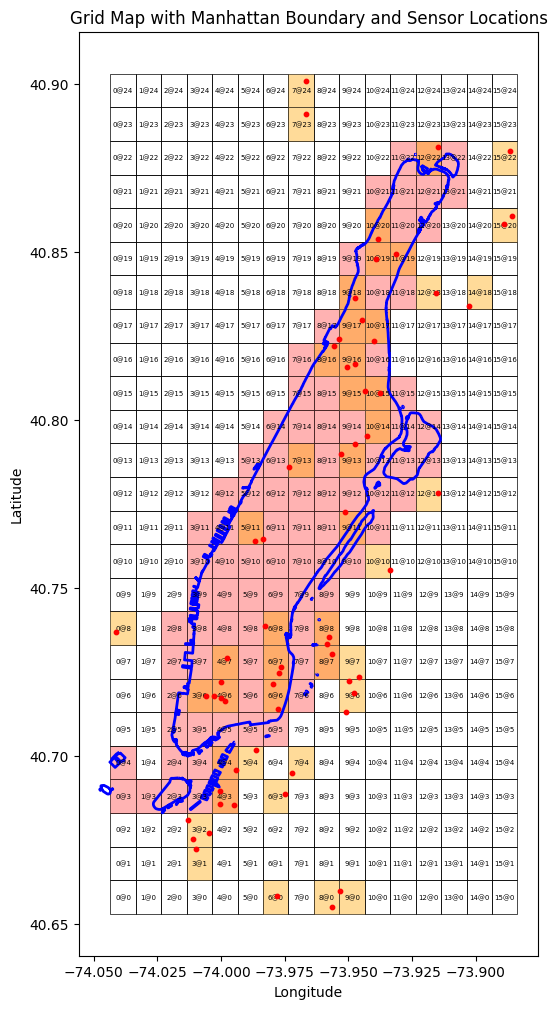

In [8]:
fig, ax = plt.subplots(figsize=(12, 12))

for _, row in grid_df.iterrows():
    rect = plt.Rectangle((row['min_lon'], row['min_lat']), cell_size, cell_size,
                         edgecolor='black', facecolor='none', linewidth=0.5)
    ax.add_patch(rect)
    plt.text((row['min_lon'] + row['max_lon']) / 2, (row['min_lat'] + row['max_lat']) / 2,
             str(row['grid_code']), ha='center', va='center', fontsize=5)
    if row['intersects_manhattan']:
        rect = plt.Rectangle((row['min_lon'], row['min_lat']), cell_size, cell_size, 
                             edgecolor='grey', facecolor='red', alpha=0.3, linewidth=0.5)
        ax.add_patch(rect)
    if row['has_sensor']:
        rect = plt.Rectangle((row['min_lon'], row['min_lat']), cell_size, cell_size, 
                             edgecolor='grey', facecolor='orange', alpha=0.4, linewidth=0.5)
        ax.add_patch(rect)
manhattan_boundary_gdf.boundary.plot(ax=ax, color='blue', linewidth=2)

ax.scatter(sensor_info_df['longitude'], sensor_info_df['latitude'], color='red', s=10, zorder=5)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Grid Map with Manhattan Boundary and Sensor Locations')

plt.show()

Save.

In [9]:
grid_df.to_csv("grid_info.csv", index=False)